In [65]:
# Imports
import torch
import torchvision
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torch.utils.data import random_split
import torch.nn as nn
import torch.nn.functional as F
from random import randint

In [15]:
# Download training dataset
#dataset = MNIST(root='data/', download=True)
# MNIST dataset (images and labels)
dataset = MNIST(root='data/', 
                train=True,
                transform=transforms.ToTensor())

In [16]:
len(dataset)

60000

In [17]:
test_dataset = MNIST(root='data/', train=False)
len(test_dataset)

10000

In [212]:
train_ds, val_ds = random_split(dataset, [50000, 10000])

In [35]:
batch_size = 128

train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size)

In [48]:
input_size = 28*28
num_classes = 10

# Logistic regression model
#model = nn.Linear(input_size, num_classes)
class MnistModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, num_classes)
        
    def forward(self, xb):
        xb = xb.reshape(-1, 784)
        out = self.linear(xb)
        return out
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))
    
model = MnistModel()

In [52]:
def evaluate(model, val_loader):
        outputs = [model.validation_step(batch) for batch in val_loader]
        return model.validation_epoch_end(outputs)
    
def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [40]:
for images, labels in train_loader:
    outputs = model(images)
    break

In [42]:
# Apply softmax for each output row
probs = F.softmax(outputs, dim=1)

In [148]:
history1 = fit(5, 0.001, model, train_loader, val_loader)
history2 = fit(5, 0.001, model, train_loader, val_loader)
history3 = fit(5, 0.001, model, train_loader, val_loader)
history4 = fit(5, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 0.6507, val_acc: 0.8547
Epoch [1], val_loss: 0.6405, val_acc: 0.8562
Epoch [2], val_loss: 0.6311, val_acc: 0.8572
Epoch [3], val_loss: 0.6223, val_acc: 0.8578
Epoch [4], val_loss: 0.6140, val_acc: 0.8587
Epoch [0], val_loss: 0.6062, val_acc: 0.8591
Epoch [1], val_loss: 0.5989, val_acc: 0.8596
Epoch [2], val_loss: 0.5921, val_acc: 0.8603
Epoch [3], val_loss: 0.5856, val_acc: 0.8613
Epoch [4], val_loss: 0.5795, val_acc: 0.8616
Epoch [0], val_loss: 0.5737, val_acc: 0.8625
Epoch [1], val_loss: 0.5682, val_acc: 0.8631
Epoch [2], val_loss: 0.5629, val_acc: 0.8635
Epoch [3], val_loss: 0.5580, val_acc: 0.8643
Epoch [4], val_loss: 0.5532, val_acc: 0.8651
Epoch [0], val_loss: 0.5487, val_acc: 0.8659
Epoch [1], val_loss: 0.5443, val_acc: 0.8663
Epoch [2], val_loss: 0.5402, val_acc: 0.8672
Epoch [3], val_loss: 0.5362, val_acc: 0.8675
Epoch [4], val_loss: 0.5324, val_acc: 0.8680


In [164]:
# Define test dataset
test_dataset = MNIST(root='data/', 
                     train=False,
                     transform=transforms.ToTensor())

In [209]:
def predict_image(img, model):
    xb = img.unsqueeze(0)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return preds[0].item()

Label: 7 , Predicted: 7


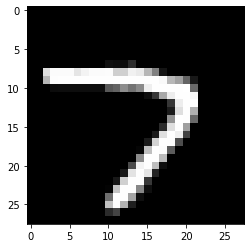

In [208]:
img, label = test_dataset[randint(0,100)]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

In [211]:
test_loader = DataLoader(test_dataset, batch_size=256)
result = evaluate(model, test_loader)
result

{'val_loss': 0.4956413805484772, 'val_acc': 0.8794921636581421}